# Shell attraction - 

### Interacting spheres, go shell by shell - compare to silly point mass thing.


In [79]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
%load_ext Cython 




The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


# Shell method:
For each shell on m1, go over all shells on m2, and add up forces
Force is sum over sum of (mS1*mS2/d**2)*overlap factor

In [80]:
%%cython
import numpy as np
import time
cimport cython
cimport numpy as cnp
cnp.import_array()

from libc.math cimport sqrt


cdef double massOfShell(double ri, double ro, double m):
    # i could improve accuracy by dropping the subtracted out 'm' - 
    # in other words calc mass outside ri and outside ro
    cdef double massInsideRi = m - m/(1 + 2*ri/m)
    cdef double massInsideRo = m - m/(1 + 2*ro/m)
    cdef double netMass = massInsideRo - massInsideRi
    return netMass

cdef double cofMassOfShell(double ri, double ro, double m):
    # not in middle, will be weighted towards r = 0
    # dR/dM ratio * span
    cdef double dMdRIn = (2.0*m*m)/((m + 2.0*ri)*(m + 2.0*ri))
    cdef double dMdROut = (2.0*m*m)/((m + 2.0*ro)*(m + 2.0*ro))
    cdef double ratio = dMdROut/dMdRIn # less than one
    cdef double cofM = ri + ratio*(ro-ri)
    return cofM

cpdef getShellForces(long numShells, double m1, double m2, double minDist, double maxDist, long dRes):
    #create shells: Each set of shells goes to r = inf. 
    #don't spread shells out evenly, they get bigger delR as r goes up. 
    cdef cnp.ndarray[double] s1m = np.empty(numShells, dtype=np.double)
    cdef cnp.ndarray[double] s1r = np.empty(numShells, dtype=np.double)
    cdef cnp.ndarray[double] s1dr = np.empty(numShells, dtype=np.double)

    cdef cnp.ndarray[double] s2m = np.empty(numShells, dtype=np.double)
    cdef cnp.ndarray[double] s2r = np.empty(numShells, dtype=np.double)
    cdef cnp.ndarray[double] s2dr = np.empty(numShells, dtype=np.double)

    cdef long n
    # https://www.wolframalpha.com/input?i=derivative+of+M+-+M%2F%281+%2B+2x%2FM%29+
    # so dm(r)/dr = 2*M^2/(M + 2*r)^2
    # a shell at r weighs delR*dm/dr
    #spread the shells out in r, put r at middle of shell, 0 - dr

    cdef double r1in = 0, r2in = 0
    cdef double r1out = 0, r2out = 0
    cdef double delR1, delR2
    cdef double dM1, dM2
    cdef double totalM1 = 0
    cdef double totalM2 = 0

    for n in range(numShells):
        delR1 = (n*n + 1/2)*m1
        r1out = r1in + delR1
        s1m[n] = massOfShell(r1in, r1out, m1)
        s1r[n] = cofMassOfShell(r1in, r1out, m1)
        s1dr[n] = delR1
        r1in = r1out
        totalM1 += s1m[n]

        delR2 = (n*n + 1/2)*m2
        r2out = r2in + delR2
        s2m[n] = massOfShell(r2in, r2out, m2)
        s2r[n] = cofMassOfShell(r2in, r2out, m2)
        s2dr[n] = delR2
        r2in = r2out
        totalM2 += s2m[n]

    print("m1 asked vs obtained:", m1, totalM1)  
    print("m2 asked vs obtained:", m2, totalM2)  
    # print("shell masses:", s1m)  
    # print("shell radii:", s1r)  
    # print("shell thicknesses:", s1dr)  
    # print("shell masses:", s2m)  
    # print("shell radii:", s2r)  
    # print("shell thicknesses:", s2dr)  

    # OK, lets calculate the forces for each distance
    distances = np.linspace(minDist, maxDist, dRes)
    cdef cnp.ndarray[double] forces = cnp.ndarray(dRes, dtype=np.double)
    cdef double d, forceSum, dm1, r1, dR1, shellForce, dSq, overlapFactor, dm2, r2, dR2
    cdef long dIndex = 0
    for d in distances:
        forceSum = 0 # total force at this distance
        # for each shell in m1, add up forces from all shells in m2
        dSq = d*d
        for n1 in range(numShells):
            dm1 = s1m[n1]
            r1 = s1r[n1]
            for n2 in range(numShells):
                overlapFactor = 1.0
                #if shells overlap, force drops with overlap factor
                r2 = s2r[n2]
                dm2 = s2m[n2]
                if r1 + r2 > d:
                    overlapFactor = d/(r1 + r2) # there is a proper expression for this...
                shellForce = overlapFactor*dm1*dm2/dSq
                forceSum += shellForce
        forces[dIndex] = forceSum
        dIndex += 1

    return distances, forces


## Force calc
### get netX, nety, netz, then force between them is m1*m2/d^2, to get vectors, we use netx/dist to get x contribution, etc.

In [81]:
%%cython
import numpy as np
import time
cimport cython
cimport numpy as cnp
cnp.import_array()

from libc.math cimport sqrt
from libc.math cimport isnan

cdef double oneOverroot3 = 0.57735026918962576450914878050195
cdef double oneOverroot2 = 0.7071067811865475244008443621048

#     # mass function
#     # mass density in my model is slightly altered from the one in the Katz paper.
#     # start with equation 3, take derivative, then get '
#     # https://www.wolframalpha.com/input?i=derivative+of+M+-+M%2F%281+%2B+2x%2FM%29+
#     # then divide by area of a sphere to get my mass density. 
#     # https://www.wolframalpha.com/input?i=%282M%5E2%2F%28M+%2B+2x%29%5E2%29%2F%284*pi*x%5E2%29
#     # then we have
#     # total mass is m, total radius is rS, so each particle we have represents 1/(4/3pirS^3) worth of volume. 
#     # we take the mass density (say a constant or by formula) and mult by the volume to get the mass of each particle.

# cdef double massOfPointConstantDensity(double m, double volS, int numPoints):
#     cdef double volPerPoint = volS/(numPoints*numPoints*numPoints)
#     return m/volS*volPerPoint # constant density, 

# return mass density at r * volperpoint
@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cdef double massOfPointLocalEnergy(double r, double m, double volS, int numPoints):
    cdef double volPerPoint = volS/(numPoints*numPoints*numPoints)
    return m*m/(2*np.pi*r*r*(m + 2*r)*(m + 2*r))*volPerPoint


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cpdef doTheWork(long numPoints, double rS1, double m1, double rS2, double m2, double minDist, double maxDist, long dRes):
    # idea - make two spheres, each with points that vary in mass with radius
    # mass points are on non interecting planes of z 
    # masses are held apart in x direction, moved together.
    # both spheres have same number of points, just masses of each point varies 
    # points in an XY plane are laid out in grid, with no points at r > r of sphere 
    # (keeping in mind where each sphere has an origin at: 0 0 0 
    
    cdef double volS1 = (4/3*np.pi*rS1*rS1*rS1)
    cdef double volS2 = (4/3*np.pi*rS2*rS2*rS2)
    cdef double cellSize1 = rS1/(2*numPoints)
    cdef double cellSize2 = rS2/(2*numPoints)

    cdef long maxNumberOfMassPoints = (numPoints)*(numPoints)*(numPoints)

    cdef cnp.ndarray[double] s1x = np.empty(maxNumberOfMassPoints, dtype=np.double)
    cdef cnp.ndarray[double] s1y = np.empty(maxNumberOfMassPoints, dtype=np.double)
    cdef cnp.ndarray[double] s1z = np.empty(maxNumberOfMassPoints, dtype=np.double)
    cdef cnp.ndarray[double] s1m = np.empty(maxNumberOfMassPoints, dtype=np.double)
    cdef cnp.ndarray[double] s2x = np.empty(maxNumberOfMassPoints, dtype=np.double)
    cdef cnp.ndarray[double] s2y = np.empty(maxNumberOfMassPoints, dtype=np.double)
    cdef cnp.ndarray[double] s2z = np.empty(maxNumberOfMassPoints, dtype=np.double)
    cdef cnp.ndarray[double] s2m = np.empty(maxNumberOfMassPoints, dtype=np.double)
    
    # make the masses as distributed points 
    cdef double com1X = 0;
    cdef double com1Y = 0;
    cdef double com1Z = 0;
    cdef double com2X = 0;
    cdef double com2Y = 0;
    cdef double com2Z = 0;
    cdef double totalMass1 = 0
    cdef double totalMass2 = 0
    cdef double r = 0
    cdef double x = 0
    cdef double y = 0
    cdef double z = 0
    cdef double m = 0
    cdef long np1 = 0
    for x in np.linspace(-rS1, rS1, numPoints):
        for y in np.linspace(-rS1, rS1, numPoints):
            for z in np.linspace(-rS1, rS1, numPoints):
                r = sqrt(x*x + y*y + z*z)
                if r < rS1:
                    #add a point to each
                    # mass 
                    m = massOfPointLocalEnergy(r, m1, volS1, numPoints)
                    if isnan(m):
                        print("m is nan", r, m1, volS1, numPoints)
                    totalMass1 += m
                    s1x[np1] = x
                    s1y[np1] = y
                    s1z[np1] = z
                    s1m[np1] = m
                    np1 += 1
                    com1X += m*x
                    com1Y += m*y
                    com1Z += m*z
                    
    cdef long np2 = 0
    for x in np.linspace(-rS2, rS2, numPoints):
        for y in np.linspace(-rS2, rS2, numPoints):
            for z in np.linspace(-rS2, rS2, numPoints):
                r = sqrt(x*x + y*y + z*z)
                if r < rS2:
                    #add a point to each
                    # mass                 
                    m = massOfPointLocalEnergy(r, m2, volS2, numPoints)
                    totalMass2 += m
                    s2x[np2] = x
                    s2y[np2] = y
                    s2z[np2] = z
                    s2m[np2] = m
                    np2 += 1
                    com2X += m*x
                    com2Y += m*y
                    com2Z += m*z
    
        
    print('centre of mass 1:',com1X, com1Y, com1Y)
    print('centre of mass 2:',com2X, com2Y, com2Y)
    print('total mass 1:',totalMass1)
    print('total mass 2:',totalMass2)
    print('MaxNumMassPoints:',maxNumberOfMassPoints)
    print('NumMassPoints:',np1, np2)
    
    # now we have our points in two numpy arrays, 
    # for each point, we want to figure out the forces and add them all up.

# Do the grunt work
    distances = np.linspace(minDist, maxDist, dRes)
    cdef long numDistances = distances.size
    cdef cnp.ndarray[double] forcesX = cnp.ndarray(numDistances, dtype=np.double)
    cdef cnp.ndarray[double] forcesY = cnp.ndarray(numDistances, dtype=np.double)
    cdef cnp.ndarray[double] forcesZ = cnp.ndarray(numDistances, dtype=np.double)
    cdef double cellSize = 2*max(cellSize1, cellSize2)
    print("cellSize",cellSize , cellSize1, cellSize2)
    cdef double s1xn = 0
    cdef double s1yn = 0
    cdef double s1zn = 0
    cdef double s1mn = 0
    cdef long distCount = 0
    cdef double d = 0
    cdef long n1 = 0
    cdef long n2 = 0
    cdef double forceSumX = 0
    cdef double forceSumY = 0
    cdef double forceSumZ = 0
    cdef double netx
    cdef double nety
    cdef double netz
    cdef double massF
    cdef double dist
    cdef double dC
    cdef double totalFactor
    cdef long numCalcs = 0
    for d in distances:
        forceSumX = 0 # we sum into this little array
        forceSumY = 0
        forceSumZ = 0
        for n1 in range(np1):
            s1xn = s1x[n1]
            s1yn = s1y[n1]
            s1zn = s1z[n1]
            s1mn = s1m[n1]
            for n2 in range(np2):
                numCalcs += 1
                netx =  d*oneOverroot3 - s1xn + s2x[n2]
                nety =  d*oneOverroot3 - s1yn + s2y[n2]
                netz =  d*oneOverroot3 - s1zn + s2z[n2]
                massF = s1mn*s2m[n2]
                dist = sqrt(netx*netx + nety*nety + netz*netz)
                # from running this program, we know that once two cells start to overlap, the force goes 
                # down as dist goes to zero. This cellSize*cellSize/dist accomplishes that.
                if dist > 1e-12:
                    if dist < cellSize:
                        dist = cellSize*cellSize/dist# [0, 0, 0] #hack to not explode - ignore close points also try dist = cellSize #
                    dC = dist*dist*dist # we need cubed, one to normalize the vector, the other two to do Newton's force
                    totalFactor = massF/dC
                    if isnan(totalFactor*netx):
                        print("totalFactor is nan",totalFactor , massF, dC, netx)
                    forceSumX += totalFactor*netx
                    forceSumY += totalFactor*nety
                    forceSumZ += totalFactor*netz
        forcesX[distCount] = forceSumX
        forcesY[distCount] = forceSumY
        forcesZ[distCount] = forceSumZ
        distCount += 1
        print("*", end="")


    # output use regular array (list)
    #print('forcesX:',forcesX)

    #cdef cnp.ndarray[double, ndim=2] 
    # cdef cnp.ndarray[double, ndim=2] forces = cnp.ndarray(dtype=np.double, ndim=2)
    # forces.append(forcesX)
    # forces.append(forcesY)
    # forces.append(forcesZ)
    
    # print('force distances:',len(forces))
    # print('forces per distance:',len(forces[0]))
    #print('force:',np.sum(forces[34][0]))
    print("!")
    return numCalcs, forcesX, forcesY, forcesZ, distances, totalMass1, totalMass2




In [84]:
#my formula for mass inside of d/2
def calcBirkhoff(d, m1, m2):
    rTouch = d/2
    m1Inside = m1 - m1/(1 + 2*rTouch/m1)
    m2Inside = m2 - m2/(1 + 2*rTouch/m2)
    force = m1Inside*m2Inside/(d*d)
    return force

r1 = 200
m1 = 1
r2 = 200
m2 = 1
# keep min dist and max dist odd weird numbers so points dont hit each other
minDist = 50.12129876523
maxDist = 1000.2212123123
dRes = 400


#calc with shells
shellDistances, shellForces = getShellForces(500, m1, m2, minDist, maxDist, dRes)
# print("forces at each dist, shell method: ", shellForces)

resolution = 12
start_time = time.time()
numCalcs, forcesX, forcesY, forcesZ, distances, mass1, mass2 = doTheWork(resolution, r1, m1, r2, m2, minDist, maxDist, dRes)
millionsPerSec = (numCalcs/1e6)/(time.time() - start_time)
print("dotheWork took:", (time.time() - start_time))
print("million per sec: ", millionsPerSec)
print("billion Calcs: ", numCalcs/1e9)




m1 asked vs obtained: 1.0 0.9999999879639884
m2 asked vs obtained: 1.0 0.9999999879639884
centre of mass 1: -6.311990881948864e-17 -5.504680562974913e-17 -5.504680562974913e-17
centre of mass 2: -6.311990881948864e-17 -5.504680562974913e-17 -5.504680562974913e-17
total mass 1: 0.009211175413311169
total mass 2: 0.009211175413311169
MaxNumMassPoints: 1728
NumMassPoints: 672 672
cellSize 16.666666666666668 8.333333333333334 8.333333333333334
****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************!
dotheWork took: 0.6692821979522705
million per sec:  269.9024000250796
billion Calcs:  0.1806336


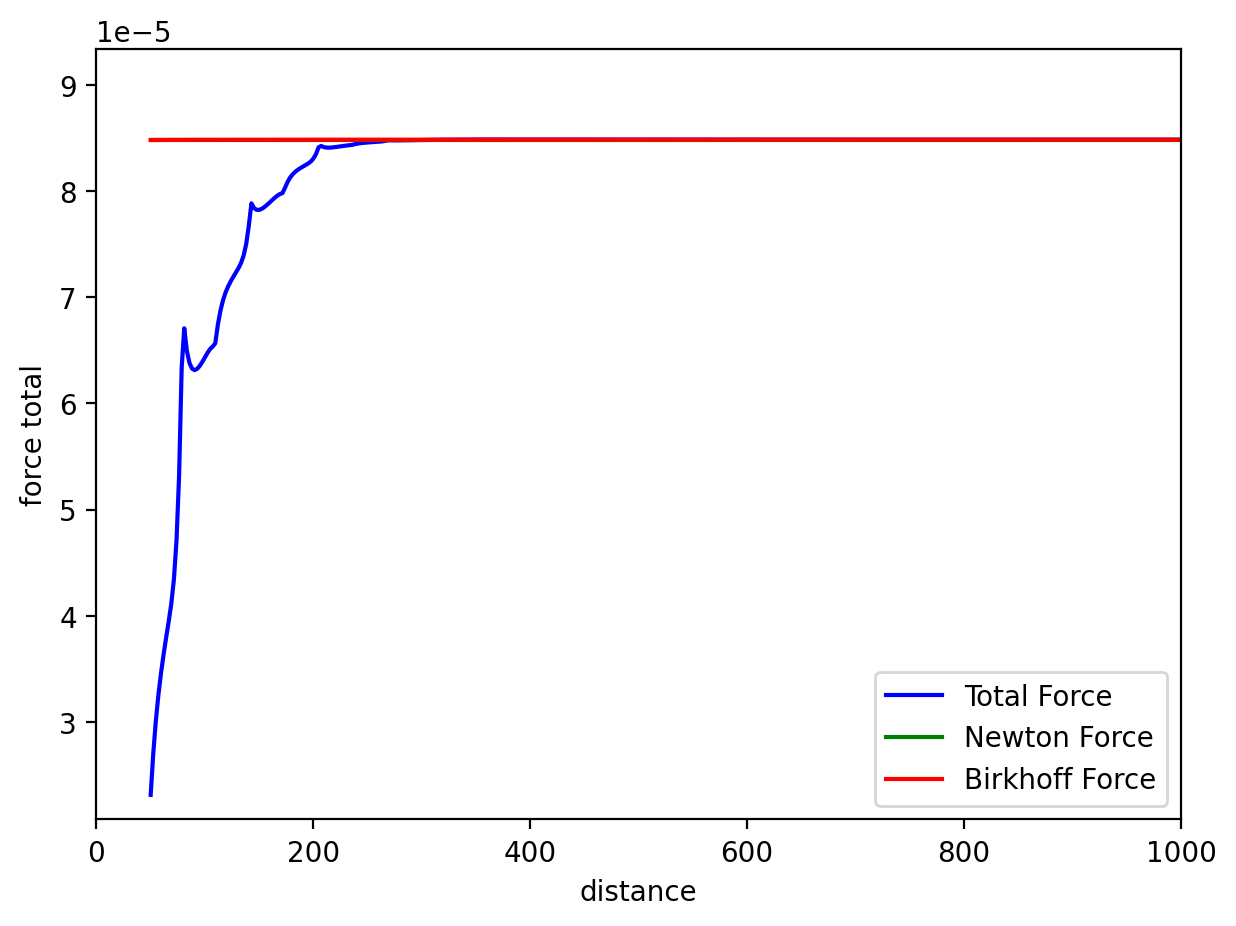

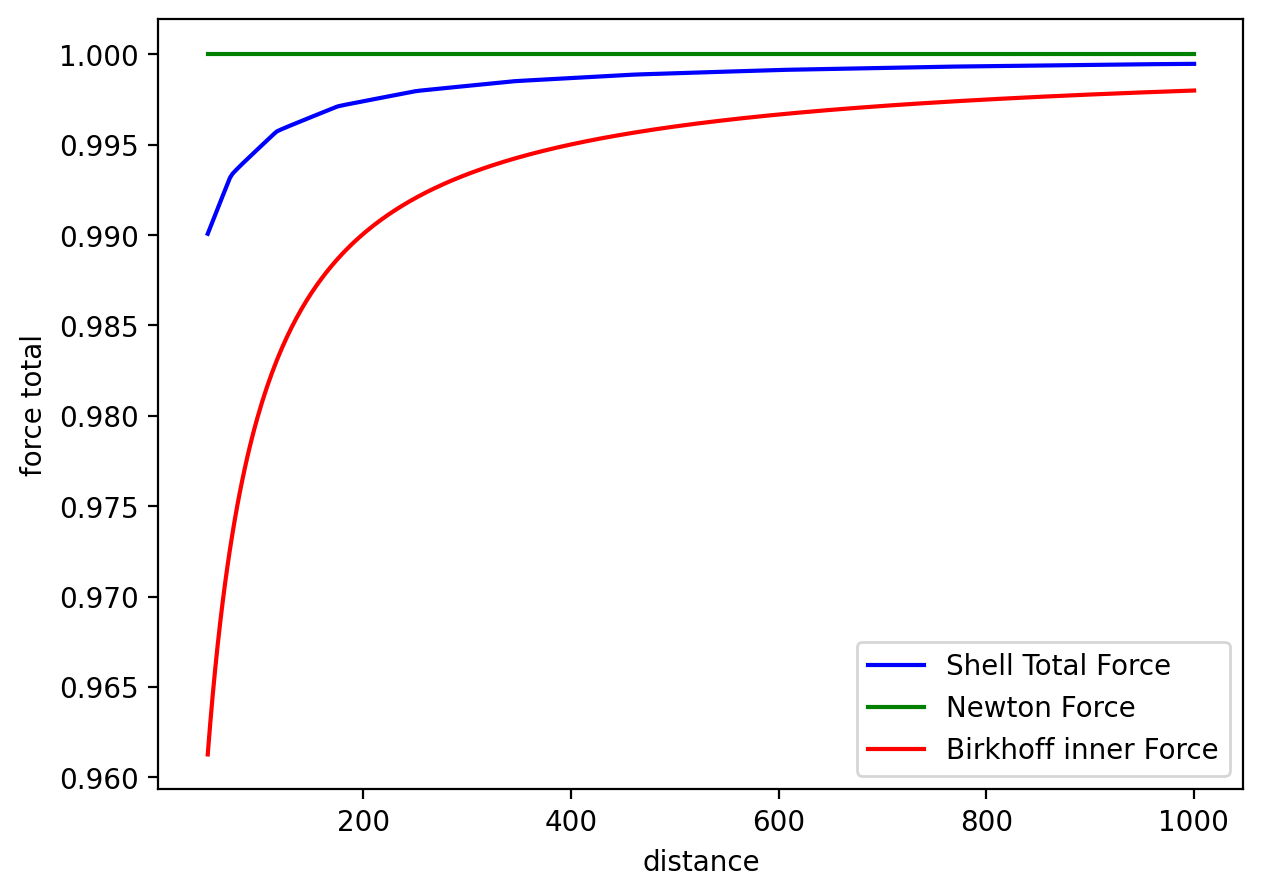

In [85]:
xForce = []
yForce = []
zForce = []
totalForce = []
maxForce = 0
minForce = 1e99
maxForceX = 0
minForceX = 1e99
maxForceZ = 0
minForceZ = 1e99
dCount = 0
newtonTotalForce = []
birkhoffTotalForce = [] # naive calculation based on mass inside of d/2
for d in distances:
    d2 = d*d
    dM = d2 # set to d2 to see errors from r^2, set dM to 1 to see actual r^2 graph
    #dM = 1
    # Sum along columns (axis=0) - get total x, y, z forces, which 
    # xyzNet = np.sum(fV, axis=0) 
    xT = forcesX[dCount]*dM
    yT = forcesY[dCount]*dM
    zT = forcesZ[dCount]*dM
    tF = np.sqrt(xT*xT + yT*yT + zT*zT)
    totalForce.append(tF)
    xForce.append(xT)
    yForce.append(yT)
    zForce.append(zT)
    maxForce = max(maxForce, tF)
    minForce = min(minForce, tF)
    maxForceX = max(maxForceX, xT)
    minForceX = min(minForceX, xT)
    maxForceZ = max(maxForceZ, zT)
    minForceZ = min(minForceZ, zT)
    newtonTotalForce.append(mass1*mass2*dM/(d*d))
    birkhoffTotalForce.append(calcBirkhoff(d, mass1, mass2)*dM)
    dCount += 1

maxDist = distances[-1]
np.savetxt('forces.csv', totalForce, delimiter=',')

if np.abs(minForce - maxForce)/maxForce < 0.001:
    minForce = 0.99999999999999*maxForce
    maxForce = 1.00000000000001*maxForce

if np.abs(minForceX - maxForceX)/maxForce < 0.001:
    minForceX = 0.99999999999999*maxForceX
    maxForceX = 1.00000000000001*maxForceX

if np.abs(minForceZ - maxForceZ)/maxForce < 0.001:
    minForceZ = 0.99999999999999*maxForceZ
    maxForceZ = 1.00000000000001*maxForceZ

# calculate some curves:
fig = plt.figure(figsize=(7, 5), dpi=200)
plt.plot(distances, totalForce, marker="none", color='blue', lw=1.5, label='Total Force')
plt.plot(distances, newtonTotalForce, marker="none", color='green', lw=1.5, label='Newton Force')
plt.plot(distances, birkhoffTotalForce, marker="none", color='red', lw=1.5, label='Birkhoff Force')

plt.xlabel('distance');
plt.ylabel('force total');
plt.legend(loc='lower right')
plt.axis((0, maxDist, minForce*0.9, maxForce*1.1));
#plt.savefig('../chapters/images/force.png', bbox_inches='tight')
plt.show()

dCount = 0
shellTotalForces = []
shellNewtonTotalForce = []
shellBirkhoffTotalForce = []
for d in shellDistances:
    d2 = d*d
    dM = d2 # set to d2 to see errors from r^2, set dM to 1 to see actual r^2 graph
    #dM = 1 
    shellTotalForces.append(shellForces[dCount]*dM)
    shellNewtonTotalForce.append(m1*m2*dM/(d2))
    shellBirkhoffTotalForce.append(calcBirkhoff(d, m1, m2)*dM)
    dCount += 1

fig = plt.figure(figsize=(7, 5), dpi=200)
plt.plot(shellDistances, shellTotalForces, marker="none", color='blue', lw=1.5, label='Shell Total Force')
plt.plot(shellDistances, shellNewtonTotalForce, marker="none", color='green', lw=1.5, label='Newton Force')
plt.plot(shellDistances, shellBirkhoffTotalForce, marker="none", color='red', lw=1.5, label='Birkhoff inner Force')
plt.xlabel('distance');
plt.ylabel('force total');
plt.legend(loc='lower right')
#plt.axis((0, maxDist, minForce*0.9, maxForce*1.1));
#plt.savefig('../chapters/images/force.png', bbox_inches='tight')
plt.show()

    
# fig = plt.figure(figsize=(7, 5), dpi=200)
# plt.plot(distances, xForce, marker="none", color='green', lw=1.5, label='Force')
# plt.xlabel('distance');
# plt.ylabel('force x');
# plt.legend(loc='lower right')
# plt.axis((0, maxDist, minForceX, maxForceX));
# #plt.savefig('../chapters/images/force.png', bbox_inches='tight')
# plt.show()


# fig = plt.figure(figsize=(7, 5), dpi=200)
# plt.plot(distances, yForce, marker="none", color='yellow', lw=1.5, label='ForceZ')
# plt.xlabel('distance');
# plt.ylabel('force z');
# plt.legend(loc='lower right')
# plt.axis((0, maxDist, minForceZ, maxForceZ));
# #plt.savefig('../chapters/images/force.png', bbox_inches='tight')
# plt.show()